In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dir ="/content/gdrive/MyDrive/dataset/photos"



In [5]:
data_dir

'/content/gdrive/MyDrive/dataset/photos'

In [6]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir     

PosixPath('/content/gdrive/MyDrive/dataset/photos')

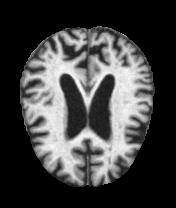

In [7]:
moderate = list(data_dir.glob('ModerateDemented/*'))
PIL.Image.open(str(moderate[0]))

In [8]:
img_height,img_width =180,180
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
)



Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [9]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [10]:
class_names= train_ds.class_names
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [12]:
resnet_model = Sequential()
pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                               input_shape=(180,180,3),
                                               pooling='avg',classes=4,
                                               weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False
    
resnet_model.add(pretrained_model)  
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(4,activation='softmax'))


tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    
)

102981632/102967424 [==============================] - 3s 0us/step


In [13]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_4 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_5 (ModuleWra  (None, 4)                2052      
 pper)                                                           
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
__________________________________

In [14]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
epochs=30
history=resnet_model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)


Epoch 1/30
160/160 [==============================] - 1028s 6s/step - loss: 1.0482 - accuracy: 0.5437 - val_loss: 0.8729 - val_accuracy: 0.5984
Epoch 2/30
160/160 [==============================] - 14s 88ms/step - loss: 0.8613 - accuracy: 0.6049 - val_loss: 0.8039 - val_accuracy: 0.6273
Epoch 3/30
160/160 [==============================] - 14s 89ms/step - loss: 0.8011 - accuracy: 0.6305 - val_loss: 0.7296 - val_accuracy: 0.6812
Epoch 4/30
160/160 [==============================] - 14s 89ms/step - loss: 0.7331 - accuracy: 0.6654 - val_loss: 0.7504 - val_accuracy: 0.6633
Epoch 5/30
160/160 [==============================] - 15s 90ms/step - loss: 0.7106 - accuracy: 0.6836 - val_loss: 0.7067 - val_accuracy: 0.6742
Epoch 6/30
160/160 [==============================] - 15s 90ms/step - loss: 0.6634 - accuracy: 0.7068 - val_loss: 0.6984 - val_accuracy: 0.6844
Epoch 7/30
160/160 [==============================] - 15s 90ms/step - loss: 0.6226 - accuracy: 0.7291 - val_loss: 0.6581 - val_accuracy:

In [16]:
resnet_model.save('resnet50alzheimer2')

INFO:tensorflow:Assets written to: resnet50alzheimer2/assets


INFO:tensorflow:Assets written to: resnet50alzheimer2/assets


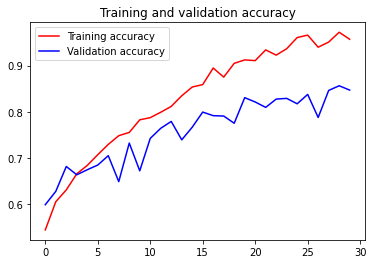

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

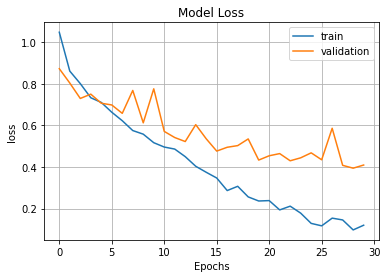

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

In [19]:
moderate = list(data_dir.glob('VeryMildDemented/*'))
image=cv2.imread(str(moderate[0]))
image_resized=cv2.resize(image,(img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 180, 180, 3)


In [20]:
pred=resnet_model.predict(image)
print(pred)

[[8.0275863e-02 1.2859148e-10 3.5999934e-03 9.1612417e-01]]


In [21]:
output_class=class_names[np.argmax(pred)]
print(output_class)

VeryMildDemented
